# Import Data

In [2]:
%cd '/Users/siyu/Downloads/Raw_dr_dataset'
import pandas as pd
dr_lab=pd.read_csv("dr_lab.csv")

/Users/siyu/Downloads/Raw_dr_dataset


In [3]:
#no_dr_lab=pd.read_csv("no_dr_lab.csv")
DEncounter=pd.read_csv("DEncounter_reduced.csv",delimiter = "\t")
Diagnosis=pd.read_csv("Diagnosis_reduced1.csv",delimiter = "\t")

In [4]:
DEncounter.columns=DEncounter.columns.str.lower()

# Delete blank records and transform data type of certain columns

In [5]:
DEncounter.isnull().sum()

encounter_id            1
patient_sk              1
race              2466851
gender               6791
age_in_years      1938386
admitted_dt_tm    1828783
dtype: int64

In [6]:
DEncounter.dropna(inplace=True)

In [7]:
DEncounter.encounter_id=DEncounter.encounter_id.astype(int)
DEncounter.patient_sk=DEncounter.patient_sk.astype(int)

In [8]:
Diagnosis.columns=Diagnosis.columns.str.lower()

In [9]:
Diagnosis.dropna(inplace=True)

In [10]:
Diagnosis.encounter_id=Diagnosis.encounter_id.astype(int)
Diagnosis.diagnosis_priority=Diagnosis.diagnosis_priority.astype(int)

# Find all the DR dignosis encounter then locate all the target patients

In [11]:
Diagnosis_target=Diagnosis[Diagnosis.diagnosis_code.isin(["362.0", "362.01", "362.02", "362.03", "362.04", "362.05", "362.06",
                                                         "E11.311", "E11.319", "E11.3211", "E11.3212", "E11.3213", "E11.3219", 
                                                          "E11.3291", "E11.3293", "E11.3299", "E11.3311", "E11.3312", "E11.3313", 
                                                          "E11.3319", "E11.3391", "E11.3392", "E11.3393", "E11.3399", "E11.3411", 
                                                          "E11.3412", "E11.3413", "E11.3419", "E11.3491", "E11.3492", "E11.3493",
                                                          "E11.3499", "E11.3511", "E11.3512", "E11.3513", "E11.3519", "E11.3521", 
                                                          "E11.3522", "E11.3523", "E11.3529", "E11.3531", "E11.3532", 
                                                          "E11.3533", "E11.3539", "E11.3541", "E11.3542", "E11.3543", "E11.3549", 
                                                          "E11.3551", "E11.3552", "E11.3553", "E11.3559", "E11.3591", "E11.3592", 
                                                          "E11.3593", "E11.3599", "E10.311", "E10.319", "E10.3211", "E10.3212", 
                                                          "E10.3213", "E10.3219", "E10.3291", "E10.3293", "E10.3299", "E10.3311", 
                                                          "E10.3312", "E10.3313", "E10.3319", "E10.3392", "E10.3393", "E10.3399", 
                                                          "E10.3411", "E10.3412", "E10.3419", "E10.3491", "E10.3492", "E10.3493", 
                                                          "E10.3499", "E10.3511", "E10.3512", "E10.3513", "E10.3519", "E10.3521", 
                                                          "E10.3522", "E10.3523", "E10.3529", "E10.3531", "E10.3532", "E10.3533", 
                                                          "E10.3539", "E10.3541", "E10.3542", "E10.3543", "E10.3549", "E10.3551", 
                                                          "E10.3552", "E10.3553", "E10.3559", "E10.3591", "E10.3592", "E10.3593", 
                                                          "E10.3599"])]

In [12]:
new=dr_lab.encounter_id.isin(Diagnosis_target.encounter_id.unique())
target_patient_key=dr_lab[new].patient_sk.unique()
patient_new=dr_lab.patient_sk.isin(target_patient_key)
dr_patient_new=dr_lab[patient_new]

## Create a new variable to indicate whether patient is diagnosed as DR during that encounter 

In [13]:
dr_patient_new['dr_encounter']=dr_patient_new.encounter_id.isin(Diagnosis_target.encounter_id.unique())
dr_patient_new.dr_encounter=dr_patient_new.dr_encounter.astype(int)

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_64108/3310620989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_patient_new['dr_encounter']=dr_patient_new.encounter_id.isin(Diagnosis_target.encounter_id.unique())
/Users/siyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Merge dr patient lab results and demographic information

In [14]:
dr_sort=dr_patient_new.sort_values(by='lab_verified_dt_tm')

In [15]:
dr=pd.merge(dr_sort,DEncounter,how="left",on="encounter_id")

In [16]:
dr.drop(columns='patient_sk_y',inplace=True)

In [17]:
dr.rename(columns={"patient_sk_x": "patient_sk"},inplace=True)

# Creatinine data construction

In [18]:
dr_creat=dr[dr["lab_procedure_name"]=='Creatinine, Serum Quantitative']
dr_creat=dr_creat.sort_values(by=['patient_sk','admitted_dt_tm']).dropna()
dr_creat_prep=dr_creat.groupby("encounter_id").first().sort_values(by=['patient_sk','admitted_dt_tm']).reset_index()
dr_creat_mean=dr_creat.groupby('encounter_id').mean()
dr_creat_final=dr_creat_prep.merge(dr_creat_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_creat_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

## Select all the information before and including the first DR diagnosis encounter

In [19]:
df_creat=pd.DataFrame()
for key in dr_creat_final.patient_sk.unique():
    if ((len(dr_creat_final[dr_creat_final.patient_sk==key].encounter_id.unique())>=3) and (dr_creat_final[dr_creat_final.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_creat_final[(dr_creat_final.patient_sk==key)&(dr_creat_final.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_creat_final[dr_creat_final.encounter_id==en_id].admitted_dt_tm.max()
        df_patient=dr_creat_final[(dr_creat_final.patient_sk==key)&(dr_creat_final.admitted_dt_tm<=time)]
        df_creat=df_creat.append(df_patient,ignore_index=True)

## Find all patients who have at least 4 encounters including the first DR diagnosis encounter and keep the last 4 encounters' informatioin

In [20]:
countdf =df_creat.groupby('patient_sk').count()
df_creat_final = df_creat.loc[df_creat['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

## Create a variable indicate the encounter order for each patient and using the mean of numeric result instead of the first measurement in each encounter to reduce measurement errors

In [21]:
df_creat_final=df_creat_final.reset_index()

In [22]:
df_creat_lt=df_creat_final.groupby('patient_sk').admitted_dt_tm.max().reset_index()

In [23]:
df_creat_lt=df_creat_lt.rename(columns={'admitted_dt_tm':'last_time'})

In [24]:
df_creat_merge=df_creat_final.merge(df_creat_lt,how='left',on='patient_sk')

In [25]:
df_creat_final=df_creat_merge.drop(columns='index')

## In order to use reverse alignment method, we need to let last encounter as time origin and calculate the time difference from origin.

In [26]:
df_creat_final['admitted_dt_tm']=pd.to_datetime(df_creat_final['admitted_dt_tm'])
df_creat_final['last_time']=pd.to_datetime(df_creat_final['last_time'])
df_creat_final['time_diff']=-(df_creat_final['last_time']-df_creat_final['admitted_dt_tm']).dt.days
df_creat_final['patient_sk']=df_creat_final.patient_sk.astype(str)

In [27]:
df_creat_final=df_creat_final[df_creat_final.patient_sk.isin(df_creat_final[df_creat_final['unit']=='mg/dL']['patient_sk'].unique())]

## Draw line plot to see the trend for each patient and a lmplot to observe the overall trend.

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

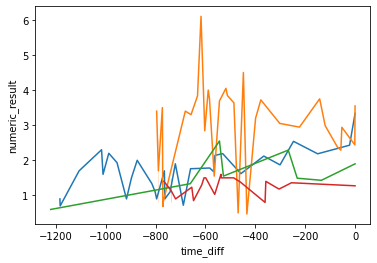

In [28]:
import seaborn as sns
sample_data=df_creat_final[df_creat_final.patient_sk.isin(df_creat_final.patient_sk.unique()[0:4])][['patient_sk','numeric_result','time_diff']]
sns.lineplot(data=sample_data, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

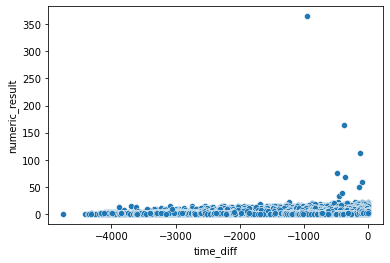

In [29]:
sns.scatterplot(data=df_creat_final,x="time_diff", y="numeric_result")

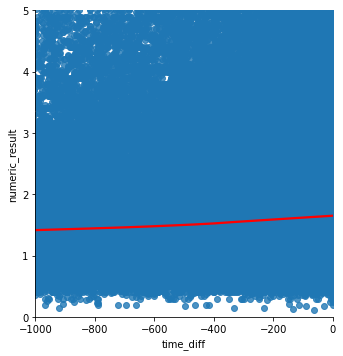

In [30]:
sns.lmplot(data=df_creat_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"}).set(xlim=(-1000,0),ylim=(0,5))

In [31]:
creat_mean=df_creat_final['numeric_result'].mean()

In [32]:
creat_std=df_creat_final['numeric_result'].std()

In [33]:
df_creat_final_reduce=df_creat_final[df_creat_final['numeric_result']<30]

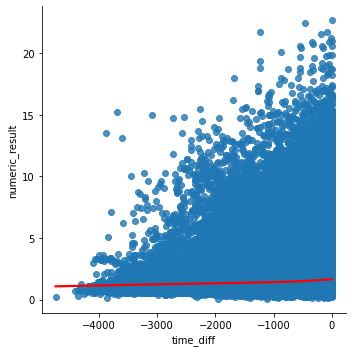

In [34]:
sns.lmplot(data=df_creat_final_reduce,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

# HbA1C data

In [35]:
dr_HbA1C=dr[dr["lab_procedure_name"]=='Hemoglobin A1C (Glycosylated Hemoglobin)']
dr_HbA1C=dr_HbA1C.sort_values(by=['patient_sk','admitted_dt_tm']).dropna()
dr_HbA1C=dr_HbA1C[dr_HbA1C['unit']=="%"]
dr_HbA1C_prep=dr_HbA1C.groupby("encounter_id").first().sort_values(by=['patient_sk','admitted_dt_tm']).reset_index()
dr_HbA1C_mean=dr_HbA1C.groupby('encounter_id').mean()
dr_HbA1C_final=dr_HbA1C_prep.merge(dr_HbA1C_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_HbA1C_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [36]:
df_HbA1C=pd.DataFrame()
for key in dr_HbA1C_final.patient_sk.unique():
    if ((len(dr_HbA1C_final[dr_HbA1C_final.patient_sk==key].encounter_id.unique())>=3) and (dr_HbA1C_final[dr_HbA1C_final.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_HbA1C_final[(dr_HbA1C_final.patient_sk==key)&(dr_HbA1C_final.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_HbA1C_final[dr_HbA1C_final.encounter_id==en_id].admitted_dt_tm.max()
        df_patient=dr_HbA1C_final[(dr_HbA1C_final.patient_sk==key)&(dr_HbA1C_final.admitted_dt_tm<=time)]
        df_HbA1C=df_HbA1C.append(df_patient,ignore_index=True)

In [37]:
countdf =df_HbA1C.groupby('patient_sk').count()
df_HbA1C_final = df_HbA1C.loc[df_HbA1C['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]
df_HbA1C_final=df_HbA1C_final.drop_duplicates()

In [38]:
df_HbA1C_final=df_HbA1C_final.reset_index()
df_HbA1C_lt=df_HbA1C_final.groupby('patient_sk').admitted_dt_tm.max().reset_index()
df_HbA1C_lt=df_HbA1C_lt.rename(columns={'admitted_dt_tm':'last_time'})
df_HbA1C_merge=df_HbA1C_final.merge(df_HbA1C_lt,how='left',on='patient_sk')
df_HbA1C_final=df_HbA1C_merge.drop(columns='index')

In [39]:
df_HbA1C_final['admitted_dt_tm']=pd.to_datetime(df_HbA1C_final['admitted_dt_tm'])
df_HbA1C_final['last_time']=pd.to_datetime(df_HbA1C_final['last_time'])
df_HbA1C_final['time_diff']=-(df_HbA1C_final['last_time']-df_HbA1C_final['admitted_dt_tm']).dt.days
df_HbA1C_final['patient_sk']=df_HbA1C_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

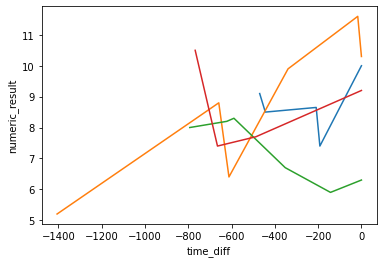

In [40]:
sample_data_1=df_HbA1C_final[df_HbA1C_final.patient_sk.isin(df_HbA1C_final.patient_sk.unique()[4:8])][['patient_sk','numeric_result','time_diff']]
sns.lineplot(data=sample_data_1, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

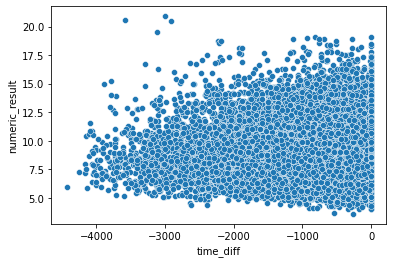

In [41]:
sns.scatterplot(data=df_HbA1C_final,x="time_diff", y="numeric_result")

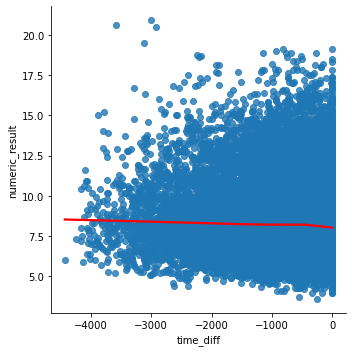

In [42]:
g2=sns.lmplot(data=df_HbA1C_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g2

In [43]:
df_HbA1C_final_reduce=df_HbA1C_final[df_HbA1C_final['numeric_result']<20]

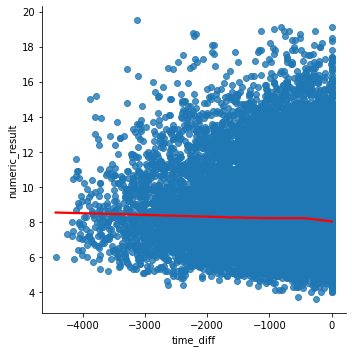

In [44]:
sns.lmplot(data=df_HbA1C_final_reduce,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

# White Blood Cell Count

In [45]:
dr_wbc=dr[dr["lab_procedure_name"]=='White Blood Cell Count']
dr_wbc=dr_wbc.sort_values(by=['patient_sk','admitted_dt_tm']).dropna()

In [46]:
dr_wbc.unit.unique()

array(['10*3', '10*3/uL', '/mm3', 'Not Mapped', 'K/mm3', '10*9', '[HPF]',
       '/uL', 'U/L', '10*9/L', 'K/mcL dup', 'm', 'mm3', 'kg', 'nL',
       '{Cells}', '/L', 'KLK units/mL', '10*6/uL'], dtype=object)

In [47]:
dr_wbc=dr_wbc[dr_wbc.unit.isin(['10*3','10*3/uL','/mm3','K/mm3','10*9','10*9/L','K/mcL dup','K/mm3'])]

In [48]:
dr_wbc.groupby('unit').count()

,encounter_id,patient_sk,lab_procedure_name,numeric_result,lab_verified_dt_tm,dr_encounter,race,gender,age_in_years,admitted_dt_tm
unit,,,,,,,,,,
/mm3,40845,40845,40845,40845,40845,40845,40845,40845,40845,40845
10*3,206790,206790,206790,206790,206790,206790,206790,206790,206790,206790
10*3/uL,222671,222671,222671,222671,222671,222671,222671,222671,222671,222671
10*9,89845,89845,89845,89845,89845,89845,89845,89845,89845,89845
10*9/L,58144,58144,58144,58144,58144,58144,58144,58144,58144,58144
K/mcL dup,71940,71940,71940,71940,71940,71940,71940,71940,71940,71940
K/mm3,136818,136818,136818,136818,136818,136818,136818,136818,136818,136818


In [49]:
dr_wbc_prep=dr_wbc.groupby("encounter_id").first().sort_values(by=['patient_sk','admitted_dt_tm']).reset_index()
dr_wbc_mean=dr_wbc.groupby('encounter_id').mean()
dr_wbc_final=dr_wbc_prep.merge(dr_wbc_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_wbc_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [50]:
df_wbc=pd.DataFrame()
for key in dr_wbc_final.patient_sk.unique():
    if ((len(dr_wbc_final[dr_wbc_final.patient_sk==key].encounter_id.unique())>=3) and (dr_wbc_final[dr_wbc_final.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_wbc_final[(dr_wbc_final.patient_sk==key)&(dr_wbc_final.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_wbc_final[dr_wbc_final.encounter_id==en_id].admitted_dt_tm.max()
        df_patient=dr_wbc_final[(dr_wbc_final.patient_sk==key)&(dr_wbc_final.admitted_dt_tm<=time)]
        df_wbc=df_wbc.append(df_patient,ignore_index=True)

In [51]:
countdf =df_wbc.groupby('patient_sk').count()
df_wbc_final = df_wbc.loc[df_wbc['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [52]:
df_wbc_final=df_wbc_final.reset_index()
df_wbc_lt=df_wbc_final.groupby('patient_sk').admitted_dt_tm.max().reset_index()
df_wbc_lt=df_wbc_lt.rename(columns={'admitted_dt_tm':'last_time'})
df_wbc_merge=df_wbc_final.merge(df_wbc_lt,how='left',on='patient_sk')
df_wbc_final=df_wbc_merge.drop(columns='index')

In [53]:
df_wbc_final['admitted_dt_tm']=pd.to_datetime(df_wbc_final['admitted_dt_tm'])
df_wbc_final['last_time']=pd.to_datetime(df_wbc_final['last_time'])
df_wbc_final['time_diff']=-(df_wbc_final['last_time']-df_wbc_final['admitted_dt_tm']).dt.days
df_wbc_final['patient_sk']=df_wbc_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

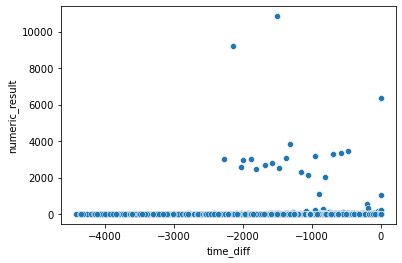

In [54]:
sns.scatterplot(data=df_wbc_final,x="time_diff", y="numeric_result")

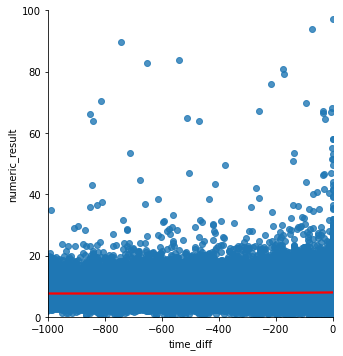

In [55]:
g3=sns.lmplot(data=df_wbc_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g3.set(ylim=(0,100),xlim=(-1000,0))

In [56]:
wbc_std=df_wbc_final['numeric_result'].std()
wbc_std

61.74120421703816

In [57]:
wbc_mean=df_wbc_final['numeric_result'].mean()
wbc_mean

8.932607671373626

In [58]:
df_wbc_final_reduce=df_wbc_final[df_wbc_final['numeric_result']<(wbc_mean+3*wbc_std)]

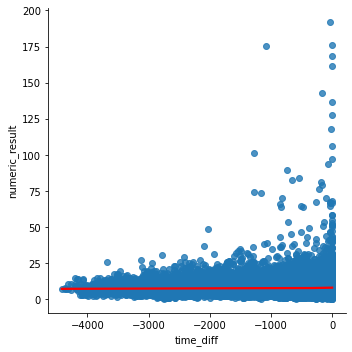

In [59]:
sns.lmplot(data=df_wbc_final_reduce,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

# Glucose

In [60]:
dr_glucose=dr[dr['lab_procedure_name']=='Glucose, Serum/Plasma Quantitative'].sort_values(by=['patient_sk','admitted_dt_tm']).dropna()
dr_glucose=dr_glucose[dr_glucose['unit']=='mg/dL']

In [61]:
dr_glucose_prep=dr_glucose.groupby("encounter_id").first().sort_values(by=['patient_sk','admitted_dt_tm']).reset_index()
dr_glucose_mean=dr_glucose.groupby('encounter_id').mean()
dr_glucose_final=dr_glucose_prep.merge(dr_glucose_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_glucose_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [62]:
df_glucose=pd.DataFrame()
for key in dr_glucose_final.patient_sk.unique():
    if ((len(dr_glucose_final[dr_glucose_final.patient_sk==key].encounter_id.unique())>=3) and (dr_glucose_final[dr_glucose_final.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_glucose_final[(dr_glucose_final.patient_sk==key)&(dr_glucose_final.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_glucose_final[dr_glucose_final.encounter_id==en_id].admitted_dt_tm.max()
        df_patient=dr_glucose_final[(dr_glucose_final.patient_sk==key)&(dr_glucose_final.admitted_dt_tm<=time)]
        df_glucose=df_glucose.append(df_patient,ignore_index=True)

In [63]:
countdf =df_glucose.groupby('patient_sk').count()
df_glucose_final = df_glucose.loc[df_glucose['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [64]:
df_glucose_final=df_glucose_final.reset_index()
df_glucose_lt=df_glucose_final.groupby('patient_sk').admitted_dt_tm.max().reset_index()
df_glucose_lt=df_glucose_lt.rename(columns={'admitted_dt_tm':'last_time'})
df_glucose_merge=df_glucose_final.merge(df_glucose_lt,how='left',on='patient_sk')
df_glucose_final=df_glucose_merge.drop(columns='index')

In [65]:
df_glucose_final['admitted_dt_tm']=pd.to_datetime(df_glucose_final['admitted_dt_tm'])
df_glucose_final['last_time']=pd.to_datetime(df_glucose_final['last_time'])
df_glucose_final['time_diff']=-(df_glucose_final['last_time']-df_glucose_final['admitted_dt_tm']).dt.days
df_glucose_final['patient_sk']=df_glucose_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

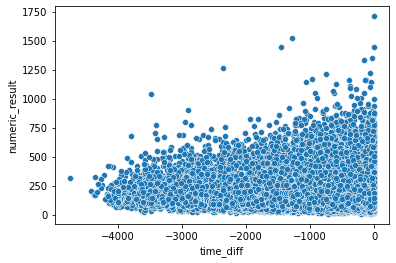

In [66]:
sns.scatterplot(data=df_glucose_final,x="time_diff", y="numeric_result")

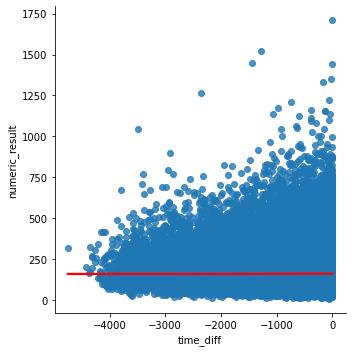

In [67]:
sns.lmplot(data=df_glucose_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

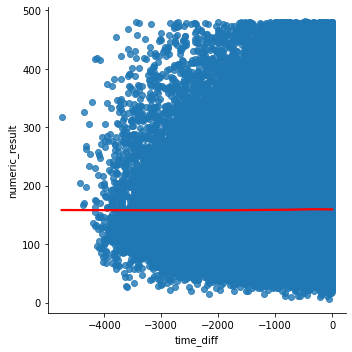

In [68]:
glucose_std=df_glucose_final['numeric_result'].std()
glucose_mean=df_glucose_final['numeric_result'].mean()
thres=glucose_mean+3*glucose_std
df_glucose_final_reduce=df_glucose_final[df_glucose_final['numeric_result']<thres]
sns.lmplot(data=df_glucose_final_reduce,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

In [69]:
patient_int=list(set(df_creat_final.patient_sk.unique())&set(df_HbA1C_final.patient_sk.unique())&set(df_wbc_final.patient_sk.unique())&set(df_glucose_final.patient_sk.unique()))

In [70]:
df_creat_int=df_creat_final[df_creat_final['patient_sk'].isin(patient_int)]

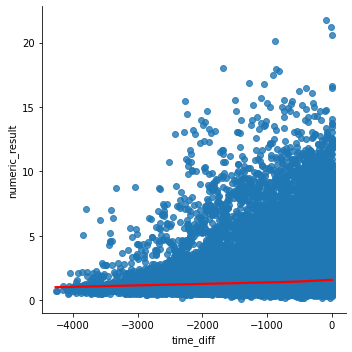

In [71]:
sns.lmplot(data=df_creat_int,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

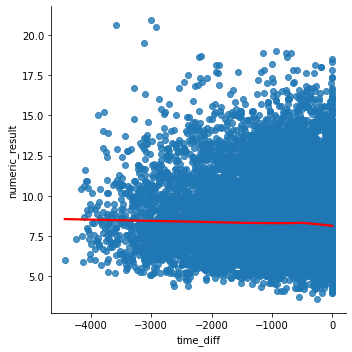

In [72]:
df_HbA1C_int=df_HbA1C_final[df_HbA1C_final['patient_sk'].isin(patient_int)]
sns.lmplot(data=df_HbA1C_int,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

In [74]:
#df_creat_int_1=df_creat_int[df_creat_int.gender=='Male']
#df_creat_int_2=df_creat_int[df_creat_int.gender=='Female']
#df_creat_int_3=df_creat_int[df_creat_int.age_in_years<=40]
#df_creat_int_4=df_creat_int[df_creat_int.age_in_years>40]

In [75]:
#sns.lmplot(data=df_creat_int_1,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

In [76]:
#sns.lmplot(data=df_creat_int_2,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

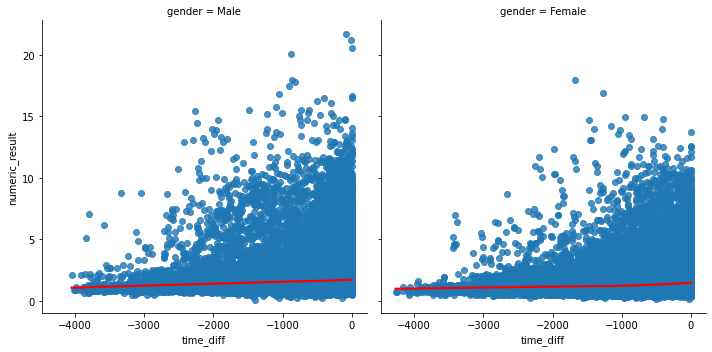

In [77]:
sns.lmplot(data=df_creat_int,x="time_diff", y="numeric_result",col='gender',lowess=True,line_kws={"color":"red"})


In [78]:
df_creat_int['elder']=(df_creat_int.age_in_years>45)

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_64108/3003066018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_creat_int['elder']=(df_creat_int.age_in_years>45)


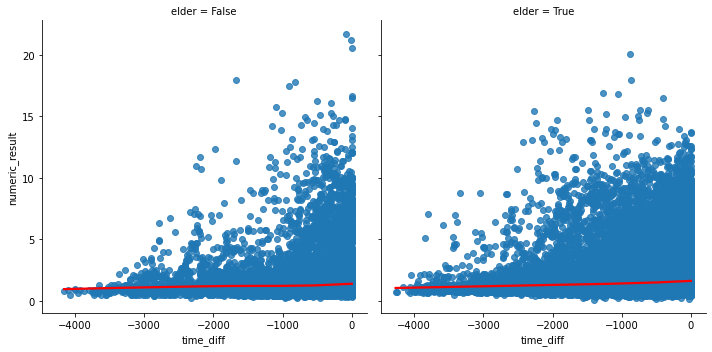

In [79]:
sns.lmplot(data=df_creat_int,x="time_diff", y="numeric_result",col='elder',lowess=True,line_kws={"color":"red"})

In [80]:
#cols_to_use = df2.columns.difference(df.columns)

In [81]:
#df_combine=df_creat_int.merge(df_HbA1C_int,how='left',on=['encounter_id','patient_sk','race','gender','age_in_years','admitted_dt_tm'])

In [82]:
#df_combine

In [83]:
#df_combine.dropna(inplace=True)

In [84]:
#df_wbc_final

# Gender, age

## HbA1C

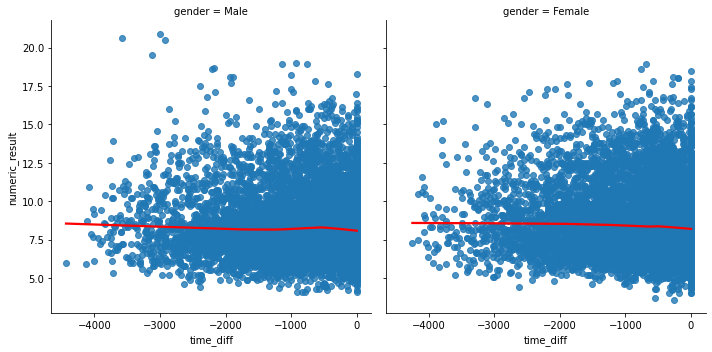

In [85]:
sns.lmplot(data=df_HbA1C_int,x="time_diff", y="numeric_result",col='gender',lowess=True,line_kws={"color":"red"})

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_64108/3168091965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HbA1C_int['elder']=(df_HbA1C_int.age_in_years>45)


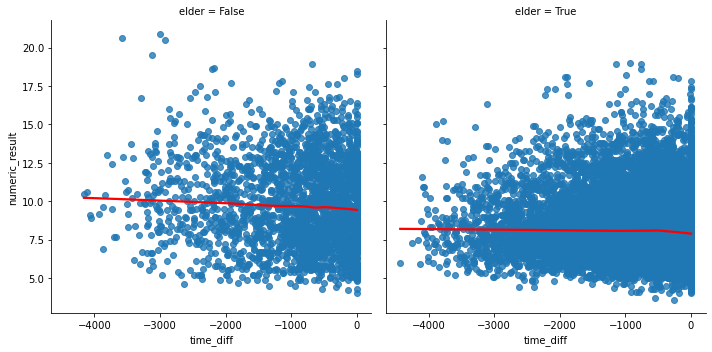

In [86]:
df_HbA1C_int['elder']=(df_HbA1C_int.age_in_years>45)
sns.lmplot(data=df_HbA1C_int,x="time_diff", y="numeric_result",col='elder',lowess=True,line_kws={"color":"red"})

In [87]:
df_wbc_int=df_wbc_final[df_wbc_final['patient_sk'].isin(patient_int)]
df_glucose_int=df_glucose_final[df_glucose_final['patient_sk'].isin(patient_int)]

## White Blood Cell

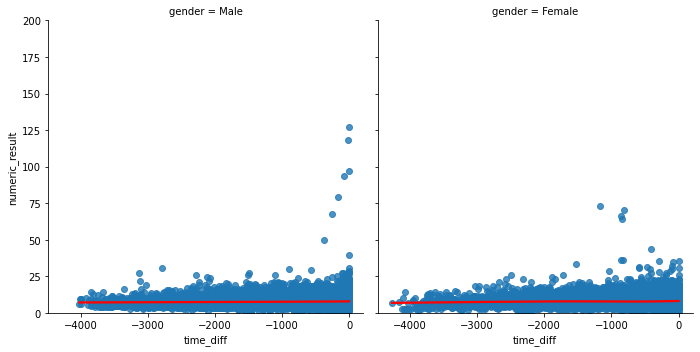

In [88]:
sns.lmplot(data=df_wbc_int,x="time_diff", y="numeric_result",col='gender',lowess=True,line_kws={"color":"red"}).set(ylim=(0,200))

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_64108/1421084369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wbc_int['elder']=(df_wbc_int.age_in_years>45)


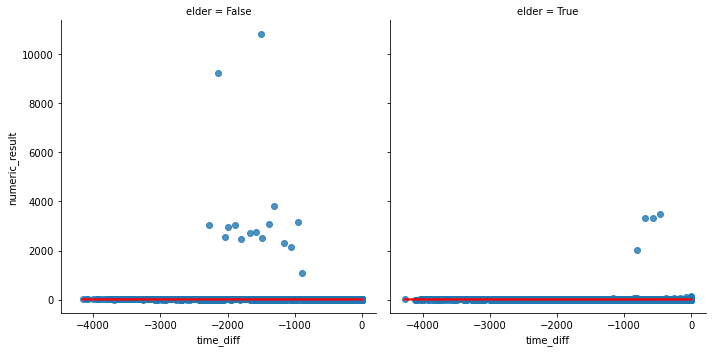

In [89]:
df_wbc_int['elder']=(df_wbc_int.age_in_years>45)
sns.lmplot(data=df_wbc_int,x="time_diff", y="numeric_result",col='elder',lowess=True,line_kws={"color":"red"})

## Glucose

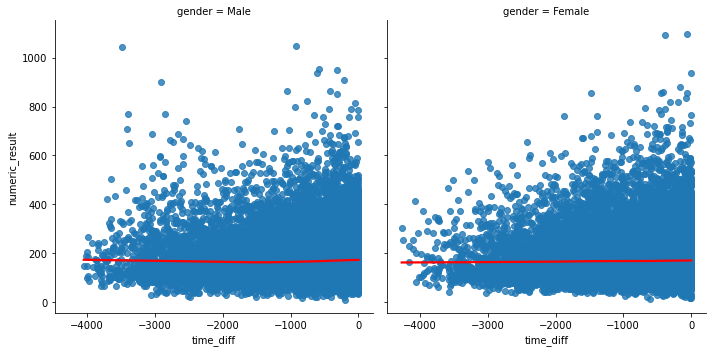

In [90]:
sns.lmplot(data=df_glucose_int,x="time_diff", y="numeric_result",col='gender',lowess=True,line_kws={"color":"red"})

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_64108/4132832772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glucose_int['elder']=(df_glucose_int.age_in_years>45)


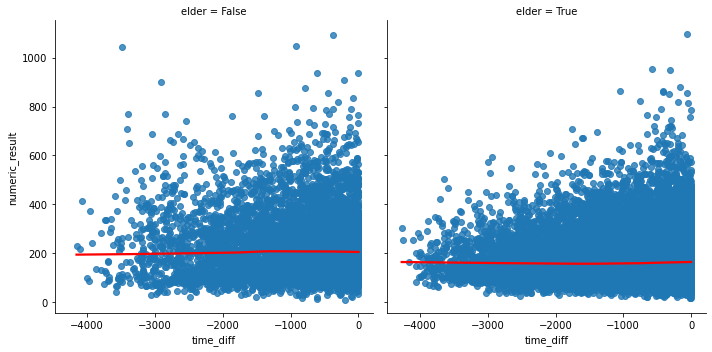

In [91]:
df_glucose_int['elder']=(df_glucose_int.age_in_years>45)
sns.lmplot(data=df_glucose_int,x="time_diff", y="numeric_result",col='elder',lowess=True,line_kws={"color":"red"})

# Discriminant Analysis (summarize multiple variables into one)

In [92]:
dr_21=dr[dr.lab_procedure_name.isin(['Hemoglobin A1C (Glycosylated Hemoglobin)', 'Blood Urea Nitrogen', 'Creatinine, Serum Quantitative', 'Glucose, Serum/Plasma Quantitative', 'Hemoglobin', 'Hematocrit', 'Calcium, Serum', 'Triglyceride, Serum', 'Potassium, Serum', 'Chloride, Serum', 'Mean Corpuscular Hemoglobin', 'Sodium, Serum', 'Mean Corpuscular Hemoglobin Concentration', 'Mean Corpuscular Volume', 'Albumin, Serum', 'Bilirubin Total Serum or Plasma Mass/Volume', 'Anion Gap', 'Aspartate Aminotransferase / SGOT', 'Alanine Aminotransferase / SGPT', 'Red Blood Cell Count', 'White Blood Cell Count'])]
dr_mean=dr_21.groupby(['patient_sk','encounter_id','lab_procedure_name']).mean().reset_index()
dr_mean=dr_mean.drop(columns=['dr_encounter','age_in_years'])
dr_final=pd.pivot_table(dr_mean, index = ['patient_sk','encounter_id'], columns = ['lab_procedure_name'], values = ['numeric_result']).dropna().reset_index()

In [93]:
dr_final.columns=['patient_sk','encounter_id','Hemoglobin A1C (Glycosylated Hemoglobin)', 'Blood Urea Nitrogen', 'Creatinine, Serum Quantitative', 'Glucose, Serum/Plasma Quantitative', 'Hemoglobin', 'Hematocrit', 'Calcium, Serum', 'Triglyceride, Serum', 'Potassium, Serum', 'Chloride, Serum', 'Mean Corpuscular Hemoglobin', 'Sodium, Serum', 'Mean Corpuscular Hemoglobin Concentration', 'Mean Corpuscular Volume', 'Albumin, Serum', 'Bilirubin Total Serum or Plasma Mass/Volume', 'Anion Gap', 'Aspartate Aminotransferase / SGOT', 'Alanine Aminotransferase / SGPT', 'Red Blood Cell Count', 'White Blood Cell Count']

In [108]:
dr_pre_var=dr[dr.lab_procedure_name.isin(['Hemoglobin A1C (Glycosylated Hemoglobin)',  'Creatinine, Serum Quantitative', 'Glucose, Serum/Plasma Quantitative', 'White Blood Cell Count'])]
dr_mean_pre=dr_pre_var.groupby(['patient_sk','encounter_id','lab_procedure_name']).mean().reset_index()
dr_mean_pre_final=dr_mean_pre.drop(columns=['dr_encounter','age_in_years'])
dr_pre_final=pd.pivot_table(dr_mean_pre_final, index = ['patient_sk','encounter_id'], columns = ['lab_procedure_name'], values = ['numeric_result']).dropna().reset_index()

In [109]:
dr_pre_final['patient_sk']=dr_pre_final['patient_sk'].astype(str)

In [112]:
dr_pre_int=dr_pre_final[dr_pre_final.patient_sk.isin(patient_int)]
dr_pre_int.columns=['patient_sk','encounter_id','Creatinine, Serum Quantitative','Glucose, Serum/Plasma Quantitative','Hemoglobin A1C (Glycosylated Hemoglobin)','White Blood Cell Count']

In [117]:
lda_prep=dr_pre_int.merge(df_creat_int[['encounter_id','time_diff']],how='left',on='encounter_id').dropna()

In [172]:
lda_prep['group']=(lda_prep.time_diff<=-365).astype('int')+1

In [173]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = lda_prep[['Creatinine, Serum Quantitative','Glucose, Serum/Plasma Quantitative','Hemoglobin A1C (Glycosylated Hemoglobin)','White Blood Cell Count']]
y = lda_prep['group']
clf = LinearDiscriminantAnalysis()
model=clf.fit(X, y)

In [174]:
model.coef_

array([[-0.10599279, -0.00135435,  0.05245273,  0.00023761]])

In [177]:
value=X.dot(model.coef_.T)

In [178]:
lda_prep['value']=value

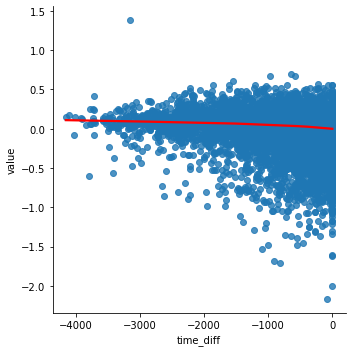

In [179]:
sns.lmplot(data=lda_prep,x="time_diff", y="value",lowess=True,line_kws={"color":"red"})

In [127]:
clf.score(X,y)

0.5627450980392157

In [136]:
lda_prep['group_2']=(lda_prep.time_diff<=-150).astype('int')+1
y_2 = lda_prep['group_2']
model_2=clf.fit(X, y_2)
print(model_2.means_)

[[  2.54640681 183.47351845   8.46254858   8.89513865]
 [  2.08148992 182.39777068   8.70464651   9.19711596]]


In [137]:
clf.score(X,y_2)

0.7258578431372549

In [141]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf_2 = QuadraticDiscriminantAnalysis()
model_3=clf_2.fit(X,y)
clf_2.score(X,y)

0.5177696078431373

In [140]:
print(model_3.means_)

[[  2.54640681 183.47351845   8.46254858   8.89513865]
 [  2.08148992 182.39777068   8.70464651   9.19711596]]


In [142]:
lda_prep

,patient_sk,encounter_id,"Creatinine, Serum Quantitative","Glucose, Serum/Plasma Quantitative",Hemoglobin A1C (Glycosylated Hemoglobin),White Blood Cell Count,time_diff,group,group_2
0,40184,234805164,1.500000,164.000000,12.4,5.900000,-897.0,2,2
1,40184,241041726,1.933333,253.000000,7.3,7.700000,-955.0,2,2
2,40184,245994764,1.760000,297.000000,10.2,9.300000,-660.0,2,2
3,40184,364897338,3.334615,145.000000,7.5,13.090909,0.0,1,1
4,40603,234375051,3.634884,277.782609,10.2,5.276923,-486.0,1,2
...,...,...,...,...,...,...,...,...,...
12172,77465820,210972005,1.900000,209.833333,7.8,7.566667,0.0,1,1
12192,84137707,431870959,3.330000,438.000000,12.0,8.900000,-38.0,1,1
12193,84137707,431880148,2.670000,150.000000,11.8,6.575000,-20.0,1,1
12194,84137707,431891153,2.260000,312.000000,11.8,8.300000,-140.0,1,1


In [143]:
dr_six_var=dr[dr.lab_procedure_name.isin(['Hemoglobin A1C (Glycosylated Hemoglobin)',  'Creatinine, Serum Quantitative', 'Glucose, Serum/Plasma Quantitative', 'White Blood Cell Count','Hematocrit','Sodium, Serum'])]
dr_mean_six=dr_six_var.groupby(['patient_sk','encounter_id','lab_procedure_name']).mean().reset_index()
dr_mean_six_final=dr_mean_six.drop(columns=['dr_encounter','age_in_years'])
dr_six_final=pd.pivot_table(dr_mean_six_final, index = ['patient_sk','encounter_id'], columns = ['lab_procedure_name'], values = ['numeric_result']).dropna().reset_index()
dr_six_final['patient_sk']=dr_six_final['patient_sk'].astype(str)
dr_six_int=dr_six_final[dr_six_final.patient_sk.isin(patient_int)]
dr_six_int

patient_sk encounter_id                 numeric_result  \
lab_procedure_name                         Creatinine, Serum Quantitative   
0                       40184    234805164                       1.500000   
1                       40184    241041726                       1.933333   
2                       40184    245994764                       1.760000   
9                       40603    234375051                       3.634884   
10                      40603    234407750                       4.050000   
...                       ...          ...                            ...   
56833                84137707    241582587                       3.800000   
56834                84137707    241926639                       4.042308   
56835                84137707    282704442                       3.860000   
56836                84137707    308358238                       3.805556   
56837                84137707    327799765                       4.442500   

                                                                  \
lab_procedure_name Glucose, Serum/Plasma Quantitative Hematocrit   
0                                          164.000000  42.000000   
1                                          253.000000  41.500000   
2                                          297.000000  41.000000   
9                                          277.782609  29.000000   
10                                         305.250000  27.000000   
...                                               ...        ...   
56833                                      145.000000  33.000000   
56834                                      177.882353  33.555556   
56835                                      138.500000  29.666667   
56836                                       91.818182  32.666667   
56837                                      150.000000  36.750000   

                                                                           \
lab_procedure_name Hemoglobin A1C (Glycosylated Hemoglobin) Sodium, Serum   
0                                                     12.40    139.000000   
1                                                      7.30    135.333333   
2                                                     10.20    134.000000   
9                                                     10.20    136.767442   
10                                                    11.30    137.750000   
...                                                     ...           ...   
56833                                                  9.00    138.000000   
56834                                                 10.70    134.692308   
56835                                                 11.35    137.285714   
56836                                                  9.20    132.722222   
56837                                                 10.80    132.250000   

                                           
lab_procedure_name White Blood Cell Count  
0                                5.900000  
1                                7.700000  
2                                9.300000  
9                                5.276923  
10                               5.366667  
...                                   ...  
56833                            9.500000  
56834                           11.960870  
56835                            9.757143  
56836                           12.593750  
56837                           12.025000  

[11575 rows x 8 columns]

In [144]:
dr_six_int.columns=['patient_sk','encounter_id','Creatinine, Serum Quantitative','Glucose, Serum/Plasma Quantitative','Hematocrit','Hemoglobin A1C (Glycosylated Hemoglobin)','Sodium, Serum','White Blood Cell Count']
lda_six=dr_six_int.merge(df_creat_int[['encounter_id','time_diff']],how='left',on='encounter_id').dropna()

,patient_sk,encounter_id,"Creatinine, Serum Quantitative","Glucose, Serum/Plasma Quantitative",Hematocrit,Hemoglobin A1C (Glycosylated Hemoglobin),"Sodium, Serum",White Blood Cell Count,time_diff
0,40184,234805164,1.500000,164.000000,42.000000,12.4,139.000000,5.900000,-897.0
1,40184,241041726,1.933333,253.000000,41.500000,7.3,135.333333,7.700000,-955.0
2,40184,245994764,1.760000,297.000000,41.000000,10.2,134.000000,9.300000,-660.0
3,40603,234375051,3.634884,277.782609,29.000000,10.2,136.767442,5.276923,-486.0
4,40603,234407750,4.050000,305.250000,27.000000,11.3,137.750000,5.366667,-518.0
...,...,...,...,...,...,...,...,...,...
11562,69816095,364745251,0.641429,188.000000,39.200000,7.9,137.142857,19.300000,0.0
11563,77465820,72754114,1.246667,131.333333,31.140000,5.4,137.833333,3.888889,-808.0
11564,77465820,172961169,3.266667,126.333333,40.700000,8.9,138.333333,9.400000,-225.0
11565,77465820,210704906,4.866667,216.000000,29.766667,8.8,135.333333,7.850000,-65.0


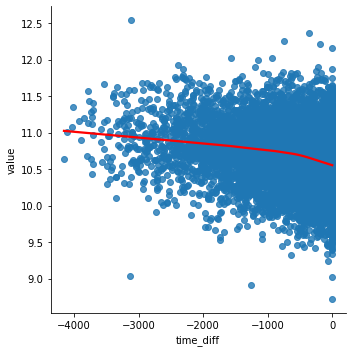

In [181]:
lda_six['group']=(lda_six.time_diff<=-90).astype('int')+1
X_six = lda_six[['Creatinine, Serum Quantitative','Glucose, Serum/Plasma Quantitative','Hematocrit','Hemoglobin A1C (Glycosylated Hemoglobin)','Sodium, Serum','White Blood Cell Count']]
y_six = lda_six['group']
model_4=clf.fit(X_six, y_six)
lda_six['value']=X_six.dot(model_4.coef_.T)
sns.lmplot(data=lda_six,x="time_diff", y="value",lowess=True,line_kws={"color":"red"})

In [182]:
model_4.coef_

array([[-0.03601051, -0.00028429,  0.0553969 ,  0.04741566,  0.06140103,
        -0.00028909]])

In [168]:
clf.score(X_six,y_six)

0.7779200819672131

In [162]:
sum(lda_six['group']==2)

5555

In [159]:
lda_six

,patient_sk,encounter_id,"Creatinine, Serum Quantitative","Glucose, Serum/Plasma Quantitative",Hematocrit,Hemoglobin A1C (Glycosylated Hemoglobin),"Sodium, Serum",White Blood Cell Count,time_diff,group
0,40184,234805164,1.500000,164.000000,42.000000,12.4,139.000000,5.900000,-897.0,2
1,40184,241041726,1.933333,253.000000,41.500000,7.3,135.333333,7.700000,-955.0,2
2,40184,245994764,1.760000,297.000000,41.000000,10.2,134.000000,9.300000,-660.0,2
3,40603,234375051,3.634884,277.782609,29.000000,10.2,136.767442,5.276923,-486.0,2
4,40603,234407750,4.050000,305.250000,27.000000,11.3,137.750000,5.366667,-518.0,2
...,...,...,...,...,...,...,...,...,...,...
11562,69816095,364745251,0.641429,188.000000,39.200000,7.9,137.142857,19.300000,0.0,1
11563,77465820,72754114,1.246667,131.333333,31.140000,5.4,137.833333,3.888889,-808.0,2
11564,77465820,172961169,3.266667,126.333333,40.700000,8.9,138.333333,9.400000,-225.0,2
11565,77465820,210704906,4.866667,216.000000,29.766667,8.8,135.333333,7.850000,-65.0,2
